# AirBnb New User Bookings

# Table of Contents
* [AirBnb New User Bookings](#AirBnb-New-User-Bookings)
	* [Introduction](#Introduction)
	* [Data Description](#Data-Description)
	* [Evaluation method](#Evaluation-method)
	* [Data Preprocessing](#Data-Preprocessing)
		* [Data Exploration](#Data-Exploration)
		* [Data Aggregation](#Data-Aggregation)
		* [Cleaning and Feature Engeneering](#Cleaning-and-Feature-Engeneering)
	* [Building a model](#Building-a-model)
		* [_Data portioning_](#_Data-portioning_)
		* [_Cross Validation Results_](#_Cross-Validation-Results_)
	* [Evaluation](#Evaluation)
		* [Model Performance for different classes](#Model-Performance-for-different-classes)
		* [Comparison with random fixed decisions](#Comparison-with-random-fixed-decisions)
		* [Feature Importance](#Feature-Importance)
	* [Summary](#Summary)


## Introduction

New users on Airbnb can book a place to stay in 34,000+ cities across 190+ countries. By accurately predicting where a new user will book their first travel experience, Airbnb can share more personalized content with their community, decrease the average time to first booking, and better forecast demand.

As a part of [Kaggle competition](https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings) AirBnb provided a list of users along with their demographics, web session records, and some summary statistics. The goal of the project was to predict in which country a new user will make his or her first booking.

I have participated in Kaggle competition and got 160th place being in top 11% among all participants, my profile can be found [here](https://www.kaggle.com/tmakarova) . Submitted solution got 0.88484 score on unseen test data.

## Data Description

There are 12 possible outcomes of the destination country: &#39;US&#39;, &#39;FR&#39;, &#39;CA&#39;, &#39;GB&#39;, &#39;ES&#39;, &#39;IT&#39;, &#39;PT&#39;, &#39;NL&#39;,&#39;DE&#39;, &#39;AU&#39;, &#39;NDF&#39; (no destination found), and &#39;other&#39;. The training and test sets are split by dates. Test data set is used for submissions in competition. Test data set contains all users with first activities after  **7/1/2014**. In the sessions dataset, the data only dates back to 1/1/2014, while the users dataset dates back to 2010.

In total, there are 4 data files provided for training:
- User data file contain information about 213451 users and 15 features including target variable. Features describe the user (age, gender), devices and applications she uses and etc.
- Session data file is the biggest among all provided files (nearly 600 Mb) and contain information about web session records for users. In total, it has 10567737 records and 6 features.
- Other two files contain some information about countries and genders

## Evaluation method

The goal is to predict five most probable destinations for the user. Performance is evaluated by Normalized Discounted Cumulative Gain (NDCG), which measures the performance of a recommendation system based on the graded relevance of the recommended entities. It varies from 0.0 to 1.0, with 1.0 representing the ideal ranking of the entities. Some details on the metric can be found [here](https://en.wikipedia.org/wiki/Discounted_cumulative_gain#Normalized_DCG) .

During evaluation of an algorithm on some test data set, NDCG is calculated for each test observation and than all values are averaged in order to generate one score value.

## Data Preprocessing 

### Data Exploration

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ModelValidation.utils as mv_utils 


% matplotlib inline


In [16]:
users = pd.read_csv("data/users.csv")
sessions = pd.read_csv("data/sessions.csv")

Target variable _country_destination_ is highly unbalanced, most cases correspond to either NDF class (no booking) or US (travel whithin US).

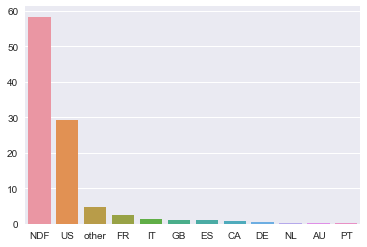

In [3]:
counts_dest = users.country_destination.value_counts(dropna=False)
perc_dest = 100 * counts_dest/users.shape[0]
sns.barplot(perc_dest.index, perc_dest.values)

Number of cases and percent in each target class

In [4]:
pd.DataFrame({"# cases" : counts_dest.apply(lambda v : "%d" % v), "% cases" : perc_dest}).transpose()

,NDF,US,other,FR,IT,GB,ES,CA,DE,NL,AU,PT
# cases,124543,62376,10094,5023,2835,2324,2249,1428,1061,762,539,217
% cases,58.3473,29.2226,4.72895,2.35323,1.32817,1.08877,1.05364,0.669006,0.49707,0.356991,0.252517,0.101663


Target variable country_destination is quite unbalanced. Most cases (nearly 60%) correspons to 'NDF' - situation when booking was not made. The second destination is 'US' - nearly 30 % of all trainig cases. This means that only 10% of cases corresponds to other destinations, where 5% relates to not listed destination ('other' group).

Some categorical features also have some unbalanced features.  

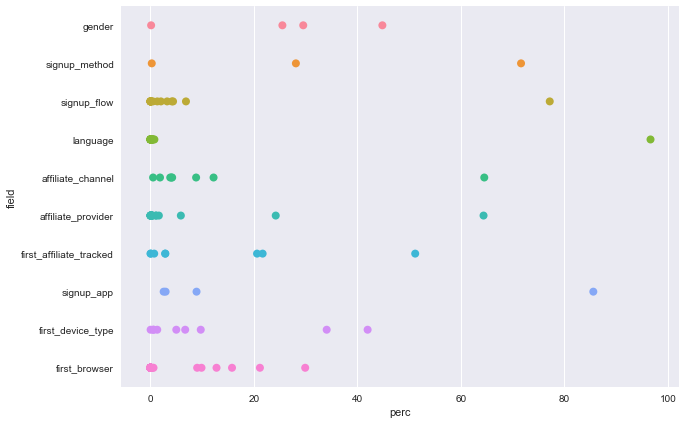

In [14]:
excl_vars = ["id","age", "date_account_created", "date_first_active", \
             "timestamp_first_active", "date_first_booking", "country_destination"]
fields_stat = mv_utils.get_levels_stat(users, excl_vars)

fig, ax = plt.subplots(figsize=(10,7))
sns.stripplot(y="field", x="perc", data=fields_stat, size=8, ax=ax)

For example, _language_ variable has 25 levels, but more than 97% correspond to English ('en').

Level distribution for session variables

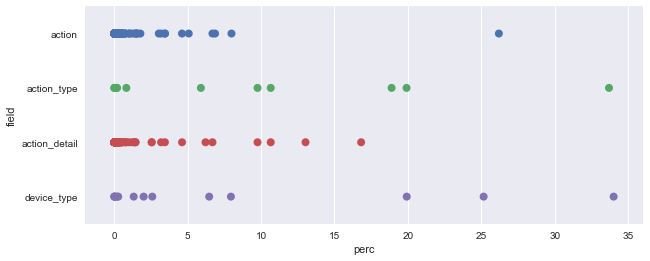

In [17]:
ses_fields_stat = get_levels_stat(sessions, ["user_id", "secs_elapsed"])

fig, ax = plt.subplots(figsize=(10,4))
sns.stripplot(y="field", x="perc", data=ses_fields_stat, size=8, ax=ax)

Percent of missed cases in users and sessions data sets (including categories like "unknown")

In [24]:
not_specified_levels = ["-unknown-", "untracked", "other/unknown", "unknown", "nan"]
print "Missing values in users data set\n" + "*"*40
print fields_stat[fields_stat.level.str.lower().isin(not_specified_levels) | fields_stat.level.isnull()] \
                .groupby("field").perc.sum()
print "\nMissing values in sessions data set\n" + "*"*40
print ses_fields_stat[ses_fields_stat.level.str.lower().isin(not_specified_levels) | ses_fields_stat.level.isnull()] \
                .groupby("field").perc.sum()

Missing values in users data set
****************************************
field
first_affiliate_tracked    54.015676
first_browser              12.773892
first_device_type           4.997400
gender                     44.829024
Name: perc, dtype: float64

Missing values in sessions data set
****************************************
field
action            0.753482
action_detail    20.414446
action_type      20.414721
device_type       1.999283
Name: perc, dtype: float64


Continious variables and outliers

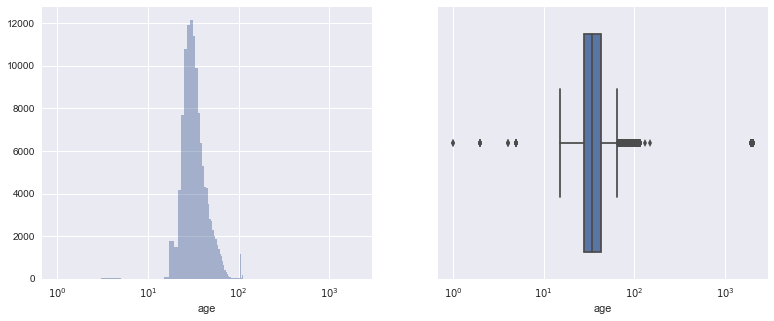

In [25]:
keep = (users.age.notnull()) 
fig, ax = plt.subplots(1,2, figsize=(13,5))
ax[0].set_xscale('log')
ax[1].set_xscale('log')
sns.distplot(users[keep].age, ax=ax[0], bins=1000, kde=False, color= sns.xkcd_rgb["denim blue"])
sns.boxplot('age', data=users[keep], ax=ax[1])

TO DO
Summary


### Data Aggregation

Session actions are presented in 3 variables. However, considering them separately often does not clarify what user actually done and if it can be important.

For example, there is a action = personalize with action\_type = data. However, variable action\_detail is very clear - wishlist\_content\_update, which is definitely can be an action which users who made a booking performed

I combine all three variables in one aggregated variable aggr\_action of specified format.

For each aggr\_action we will define a short name (agg\_action\_number). We will create a table with full and short names for actions. Giving number for each action we will order them by percent of users, who used that action (agg\_action\_0 is the most common action among users).

This kind of renaming is not important for the algorithm, but can be useful for further exploration and interpretation.

In total there are 467 unique aggregated actions. Some part of these actions were used quite rarely by the users.

We will add some simple classification of actions mostly to exclude those which were rarely used. All actions which were used by less than 1% of users were combined in special &quot;other&quot; group (called &quot;agg\_action\_other&quot;). However, some rarely used actions could still be related to booking activity. In order not to lose this information, actions from &quot;other&quot; group were further combined if they contained the same key\_word (called &quot;agg\_action\_other\_[key\_word]&quot;). A simple list of key words were used: [&quot;host&quot;, &quot;book&quot;, &quot;wishlist&quot;, &quot;reserv&quot;, &quot;transl&quot;, &quot;coupon&quot;].

Note that all actions which were used by more than 1% of users, were not grouped in any way.  After grouping there 150 unique action groups. Note that use of 1% threshold is quite arbitrary and can be reconsidered in further analysis.

Pivot sessions dataset and merge it with users data by user\_id field. As a result, in combined dataset for each user\_id there are:

- 15 variable coming from users data (age, gender, etc);
- 150 actions (coded aggregated and grouped) with corresponding number of uses (number of sessions). If a user did not perform an action, value is set to NaN.
- 14 types of devices with corresponding number of uses (number of sessions). If a user did not use specific type of device, value is set to NaN.
- Total duration of all sessions for a user
- Total number of actions

In total, combined dataset has 213451 lines (users) and 182 variables.

Note that, only around 35% of users have session data. It is not clear how to impute missing data for all other users and if it makes sense at all. This fact imposes certain restrictions on the choice of classification algorithm.

### Cleaning and Feature Engeneering

Simple basic cleaning was performed. 

- Date account created was transformed into three variables : year, date, month;
- Date first active was transformed into three variables : year, date, month;
- Session duration is transformed into days
- Action variables are transformed to percentages – percentage of times when specific action was performed by the user
- Clean age variable and remove age below 14 and over 95.
- Fill Na values with -1


## Building a model

Note that, only around 35% of users have session data. It is not clear how to impute missing data for all other users and if it makes sense at all. This fact imposes certain restrictions on the choice of classification algorithm.

Decision trees are known be good in handling data of mixed type and data with missing values. Decision trees are also known to have often weaker predictive power in comparison with some other algorithms. However, using of various ensemble methods (like boosting or random forest) can significantky improve predictive power. 

I will use Gradient Boosting Trees (GBT) and Random Forest (RF) for multiclass classification. As a comparison, I will also use Random Forest.

#### _Data portioning_

I randomly split the data into two groups: train and evaluation (90% and 10%). Train part is used for model training and optimization of parameters with cross validation. During cross validation part of the data is used for training and part of the data is used for evaluation, so that model performance is always estimated on unseen data. Cross validation has a few iterations when data is split in different ways, at the end scores can be averaged and give single performance estimation.

Once models and parameters are selected, they can be trained on the whole train data and applied to untouched evaluation data part. Evaluation step is important in order to provide estimate about model performance in real conditions.


#### _Cross Validation Results_

In [71]:
xgb_parvar = pd.read_csv("ModelValidation/xgb_parvar_add.csv")
rf_parvar = pd.read_csv("ModelValidation/rf_parvar.csv")

For XGB I considered three parameters for tuning: number of estimators, learning rate and tree depth. 

First for fixed tree depth (equal to 6) learning rate and number of estimators were varied in ranges:
 * learning rate : 0.1, 0.15, 0.2, 0.3
 * number of estimators: 20, 25, 30:10:100
 
 Once best learning rate and number of estimators were fixed, a few values of tree depth were considerd:
 * tree depth: 3, 6, 8, 10 

Next results of 3-fold cross validation on training data set are presented

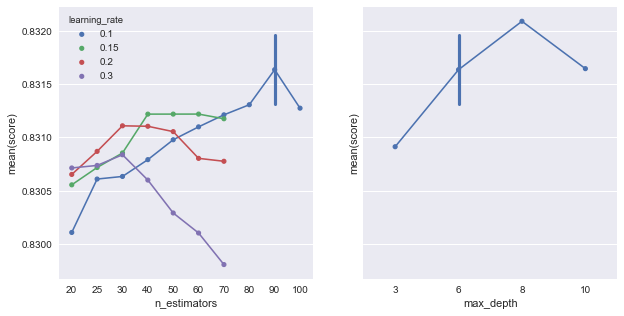

In [73]:
fig, ax = plt.subplots(1,2, figsize=(10,5), sharey=True)
colormap = plt.cm.gist_ncar
plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, 3)])

sns.set_style("darkgrid")
sns.pointplot(x="n_estimators", y="score", data=xgb_parvar[xgb_parvar.max_depth==6],
              hue="learning_rate", scale=0.5, ax=ax[0])
sns.pointplot(x="max_depth", y="score", data=xgb_parvar[(xgb_parvar.n_estimators==90) &
                                (xgb_parvar.learning_rate==0.1)], scale=0.5, ax=ax[1])



Learning rates 0.1 and 0.15 with number of estimators greater or equal to 40 outperformed other model runs. 
Pair (0.1, 90) was selected as the best option from performed calculatiom, note that it is quite stable and performance in close neighborhood almost doest not change. Next, for fixed pair of learning rate and number of estimators I calculated a few values of tree depth and selected __this value__ as optimal.

This two step procedure was performed only because of computational issues only, since it takes time to calculated a lot of model runs.

For Random Forest Model I considered two parameters:
 * number of estimators : 100, 200, 300, 400
 * number of features : 15, 50, 100, 150


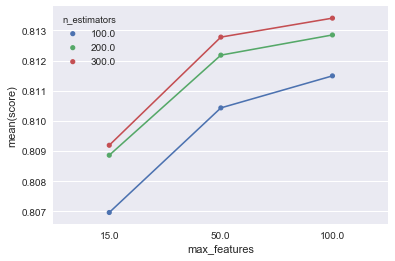

In [63]:
sns.pointplot(x="max_features", y="score", data=rf_parvar, hue="n_estimators", scale=0.5)

As a final model I will use GBM with 

## Evaluation

### Model Performance for different classes

### Comparison with random fixed decisions

### Feature Importance

## Summary